# A Quantum-Enhanced LSTM Layer

One field that so far has been poorly explored in Quantum Machine Learning is Natural Language Processing (NLP), the sub-field of Artificial Intelligence that gives computers the ability to read, write and to some extent comprehend written text. 

As documents are usually presented as sequences of words, historically one of the most successful techniques to manipulate this kind of data has been the Recurrent Neural Network architecture, and in particular a variant called Long Short-Term Memory (LSTM). LSTMs allowed machines to perform translations, classification and intent detection with state-of-the-art accuracy until the advent of Transformer networks. Still, it’s interesting at least from an educational point of view to dig into LSTMs to see what good quantum computing may bring to the field. For a more thorough discussion, please refer to “Quantum Long Short-Term Memory” by Chen, Yoo and Fang (arXiv:2009.01783) and “Recurrent Quantum Neural Networks” by J. Bausch (arXiv:2006.14619).

In [1]:
# !pip install -r requirements.txt

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qlstm_pennylane import QLSTM

c:\Users\cpb5867\Anaconda3\envs\QLSTM\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Here we define the possible tags: determinant, noun, verb.

In [3]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

The function below tokenizes the sentence and matches the label to each word.

In [4]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

Now we can prepare the input dataset.

In [5]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Entities: {0: 'DET', 1: 'NN', 2: 'V'}


The idea is to pass the two sequences through the LSTM, which will output the hidden array of vectors [h_0, h_1, h_2, h_3, h_4], one for each word. A dense layer “head” is attached to the LSTM’s outputs to calculate the probability that each word may be a determinant, noun or verb.

In [6]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [7]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 300

In [8]:
model_classical = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

Following the example from the PyTorch website, we train the two networks (classical and quantum LSTM) for 300 epochs. 

In [9]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
            
            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history

In [10]:
history_classical = train(model_classical, n_epochs)

Epoch 1 / 300: Loss = 1.083 Acc = 0.44
Epoch 2 / 300: Loss = 1.079 Acc = 0.44
Epoch 3 / 300: Loss = 1.074 Acc = 0.44
Epoch 4 / 300: Loss = 1.070 Acc = 0.44
Epoch 5 / 300: Loss = 1.065 Acc = 0.44
Epoch 6 / 300: Loss = 1.061 Acc = 0.44
Epoch 7 / 300: Loss = 1.057 Acc = 0.44
Epoch 8 / 300: Loss = 1.053 Acc = 0.44
Epoch 9 / 300: Loss = 1.049 Acc = 0.44
Epoch 10 / 300: Loss = 1.045 Acc = 0.44
Epoch 11 / 300: Loss = 1.040 Acc = 0.44
Epoch 12 / 300: Loss = 1.036 Acc = 0.44
Epoch 13 / 300: Loss = 1.032 Acc = 0.44
Epoch 14 / 300: Loss = 1.028 Acc = 0.44
Epoch 15 / 300: Loss = 1.024 Acc = 0.44
Epoch 16 / 300: Loss = 1.020 Acc = 0.44
Epoch 17 / 300: Loss = 1.016 Acc = 0.44
Epoch 18 / 300: Loss = 1.012 Acc = 0.44
Epoch 19 / 300: Loss = 1.007 Acc = 0.44
Epoch 20 / 300: Loss = 1.003 Acc = 0.44
Epoch 21 / 300: Loss = 0.999 Acc = 0.44
Epoch 22 / 300: Loss = 0.994 Acc = 0.44
Epoch 23 / 300: Loss = 0.990 Acc = 0.44
Epoch 24 / 300: Loss = 0.985 Acc = 0.44
Epoch 25 / 300: Loss = 0.981 Acc = 0.44
Epoch 26 

In [11]:
def print_result(model):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [12]:
print_result(model_classical)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


In [13]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [14]:
history_quantum = train(model_quantum, n_epochs)

Epoch 1 / 300: Loss = 1.071 Acc = 0.44
Epoch 2 / 300: Loss = 1.070 Acc = 0.44
Epoch 3 / 300: Loss = 1.069 Acc = 0.44
Epoch 4 / 300: Loss = 1.068 Acc = 0.44
Epoch 5 / 300: Loss = 1.068 Acc = 0.44
Epoch 6 / 300: Loss = 1.067 Acc = 0.44
Epoch 7 / 300: Loss = 1.066 Acc = 0.44
Epoch 8 / 300: Loss = 1.066 Acc = 0.44
Epoch 9 / 300: Loss = 1.065 Acc = 0.44
Epoch 10 / 300: Loss = 1.065 Acc = 0.44
Epoch 11 / 300: Loss = 1.064 Acc = 0.44
Epoch 12 / 300: Loss = 1.064 Acc = 0.44
Epoch 13 / 300: Loss = 1.064 Acc = 0.44
Epoch 14 / 300: Loss = 1.063 Acc = 0.44
Epoch 15 / 300: Loss = 1.063 Acc = 0.44
Epoch 16 / 300: Loss = 1.062 Acc = 0.44
Epoch 17 / 300: Loss = 1.062 Acc = 0.44
Epoch 18 / 300: Loss = 1.062 Acc = 0.44
Epoch 19 / 300: Loss = 1.062 Acc = 0.44
Epoch 20 / 300: Loss = 1.061 Acc = 0.44
Epoch 21 / 300: Loss = 1.061 Acc = 0.44
Epoch 22 / 300: Loss = 1.061 Acc = 0.44
Epoch 23 / 300: Loss = 1.061 Acc = 0.44
Epoch 24 / 300: Loss = 1.060 Acc = 0.44
Epoch 25 / 300: Loss = 1.060 Acc = 0.44
Epoch 26 

In [15]:
print_result(model_quantum)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


### Plot the training history

In [16]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM loss", color='orange', linestyle='dashed')
    ax1.plot(loss_q, label="Quantum LSTM loss", color='red', linestyle='solid')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM accuracy", color='steelblue', linestyle='dashed')
    ax2.plot(acc_q, label="Quantum LSTM accuracy", color='blue', linestyle='solid')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.1)
    #plt.legend(loc="upper right")
    fig.legend(loc="upper right", bbox_to_anchor=(1,0.8), bbox_transform=ax1.transAxes)

    plt.savefig("pos_training.pdf")
    plt.savefig("pos_training.png")
    plt.show()

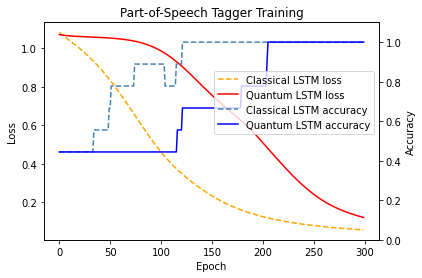

In [17]:
plot_history(history_classical, history_quantum)

The loss function decreases as a function of the training epoch, and after 300 epochs both networks are able to tag correctly the first sentence. Due to the complexity of the simulation of the quantum circuit, it took approximatively 15 minutes to finish the training, to be compared to a mere 8 seconds for the classical case. 